In [2]:
!nvidia-smi

Sat Dec  7 12:50:26 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.107.02             Driver Version: 550.107.02     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        Off |   00000000:81:00.0 Off |                  Off |
| 34%   39C    P8             13W /  450W |     571MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [53]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q git+https://github.com/roboflow/supervision.git
!pip install -q accelerate
!pip install -q roboflow
!pip install -q torchmetrics
!pip install -q "albumentations>=1.4.5"

In [28]:
import cv2
import torch
import random
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
import requests
import roboflow
import numpy as np
import torchvision
import transformers
from PIL import Image
import pytorch_lightning
import supervision as sv
import pytorch_lightning as pl
from torchvision.ops import nms
import matplotlib.pyplot as plt
from pytorch_lightning import Trainer
from torch.utils.data import DataLoader
from transformers import AutoModelForObjectDetection, AutoImageProcessor
%matplotlib inline

print(
    "roboflow:", roboflow.__version__,
    "; supervision:", sv.__version__,
    "; transformers:", transformers.__version__,
    "; pytorch_lightning:", pytorch_lightning.__version__
)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Wed_Nov_22_10:17:15_PST_2023
Cuda compilation tools, release 12.3, V12.3.107
Build cuda_12.3.r12.3/compiler.33567101_0
torch:  2.5 ; cuda:  cu124
roboflow: 1.1.49 ; supervision: 0.26.0rc1 ; transformers: 4.47.0.dev0 ; pytorch_lightning: 2.4.0


In [29]:
CHECKPOINT = "PekingU/rtdetr_r50vd_coco_o365"
DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

model = AutoModelForObjectDetection.from_pretrained(CHECKPOINT).to(DEVICE)
image_processor = AutoImageProcessor.from_pretrained(CHECKPOINT)

Could not load the custom kernel for multi-scale deformable attention: /mnt/home/hualiu/.cache/torch_extensions/py312_cu124/MultiScaleDeformableAttention/MultiScaleDeformableAttention.so: cannot open shared object file: No such file or directory
Could not load the custom kernel for multi-scale deformable attention: /mnt/home/hualiu/.cache/torch_extensions/py312_cu124/MultiScaleDeformableAttention/MultiScaleDeformableAttention.so: cannot open shared object file: No such file or directory
Could not load the custom kernel for multi-scale deformable attention: /mnt/home/hualiu/.cache/torch_extensions/py312_cu124/MultiScaleDeformableAttention/MultiScaleDeformableAttention.so: cannot open shared object file: No such file or directory
Could not load the custom kernel for multi-scale deformable attention: /mnt/home/hualiu/.cache/torch_extensions/py312_cu124/MultiScaleDeformableAttention/MultiScaleDeformableAttention.so: cannot open shared object file: No such file or directory
Could not load t

In [30]:
import requests
from PIL import Image

URL = "https://media.roboflow.com/notebooks/examples/dog.jpeg"

image = Image.open(requests.get(URL, stream=True).raw)
inputs = image_processor(image, return_tensors="pt").to(DEVICE)

with torch.no_grad():
    outputs = model(**inputs)

w, h = image.size
results = image_processor.post_process_object_detection(
    outputs, target_sizes=[(h, w)], threshold=0.3)

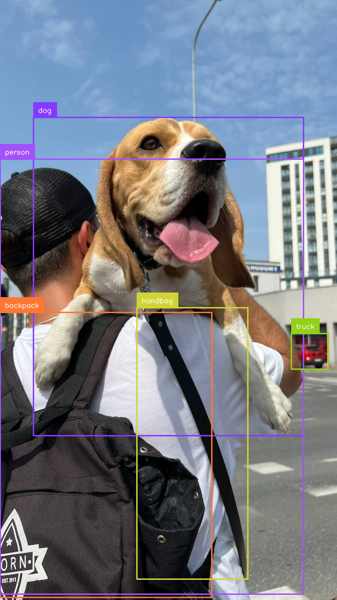

In [31]:
import supervision as sv
detections = sv.Detections.from_transformers(results[0]).with_nms(threshold=0.1)
labels = [
    model.config.id2label[class_id]
    for class_id
    in detections.class_id
]

annotated_image = image.copy()
annotated_image = sv.BoxAnnotator().annotate(
    annotated_image, detections)
annotated_image = sv.LabelAnnotator().annotate(
    annotated_image, detections, labels=labels)
annotated_image.thumbnail((600, 600))
annotated_image

In [32]:
DATASET_ROOT = "/mnt/cs/cs153/projects/bbz-huaze/datasets/KITTI-7"
ANNOTATION_FILE_NAME = "_annotations.coco.json"

TRAIN_DIRECTORY = os.path.join(DATASET_ROOT, "train")
VAL_DIRECTORY = os.path.join(DATASET_ROOT, "valid")
TEST_DIRECTORY = os.path.join(DATASET_ROOT, "test")

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(
        self,
        image_directory_path: str,
        image_processor,
        train: bool = True
    ):
        annotation_file_path = os.path.join(image_directory_path, ANNOTATION_FILE_NAME)
        super(CocoDetection, self).__init__(image_directory_path, annotation_file_path)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        images, annotations = super(CocoDetection, self).__getitem__(idx)
        image_id = self.ids[idx]
        annotations = {'image_id': image_id, 'annotations': annotations}
        encoding = self.image_processor(images=images, annotations=annotations, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]

        return pixel_values, target


TRAIN_DATASET = CocoDetection(
    image_directory_path=TRAIN_DIRECTORY,
    image_processor=image_processor,
    train=True)
VAL_DATASET = CocoDetection(
    image_directory_path=VAL_DIRECTORY,
    image_processor=image_processor,
    train=False)
TEST_DATASET = CocoDetection(
    image_directory_path=TEST_DIRECTORY,
    image_processor=image_processor,
    train=False)

print("Number of training examples:", len(TRAIN_DATASET))
print("Number of validation examples:", len(VAL_DATASET))
print("Number of test examples:", len(TEST_DATASET))

loading annotations into memory...
Done (t=0.16s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Number of training examples: 5223
Number of validation examples: 1495
Number of test examples: 746


In [34]:
# select random image
image_ids = TRAIN_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

# load image and annotatons
image = TRAIN_DATASET.coco.loadImgs(image_id)[0]
annotations = TRAIN_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(TRAIN_DATASET.root, image['file_name'])
image = cv2.imread(image_path)

# annotate
detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)

# we will use id2label function for training
categories = TRAIN_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}

labels = [
    f"{id2label[class_id]}"
    for _, _, class_id, _
    in detections
]

box_annotator = sv.BoxAnnotator()
frame = box_annotator.annotate(scene=image, detections=detections, labels=labels)

sv.show_frame_in_notebook(image, (16, 16))

Image #2646


AttributeError: type object 'Detections' has no attribute 'from_coco_annotations'